In [2]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
from sklearn.cluster import KMeans
import scipy as sp
from scipy import linalg
from sklearn.decomposition import SparsePCA
from sklearn.mixture import GaussianMixture

from PIL import Image
import cairosvg

In [3]:
from rfest import splineLG, splineLNP, splineLNLN
from rfest import build_design_matrix, get_spatial_and_temporal_filters

In [15]:
#pull the variables that are needed from this
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig8.hdf5", "r")

#get the data for plotting the sd image

dims = np.array(f1['example_spline_dims'])
sta = np.array(f1['example_spline_sta'])
spl = np.array(f1['example_spline_spl'])
real_time_lag = np.array(f1['real_time_lag'])
time_points = np.array(f1['time_points'])

f1.close()

Text(0, 0.5, 'Time')

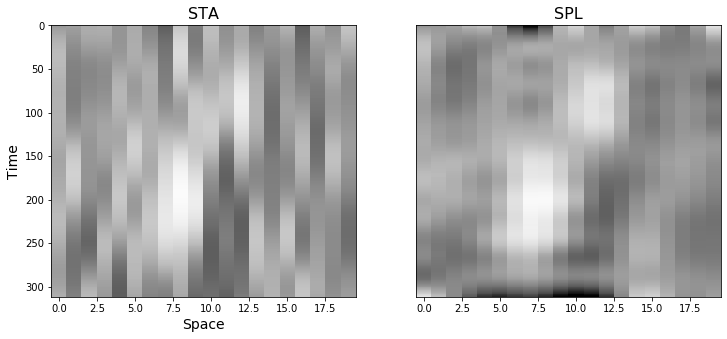

In [12]:
def norm(x): 
    # dividing by the norm = turning a RF into unit vector, 
    # not necessary, but for better visualization
    return x / np.linalg.norm(x) 


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(norm(sta.reshape(dims)), aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
ax[1].imshow(norm(spl.reshape(dims)), aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)


titles = ['STA', 'SPL']
for i in range(0, 2):
    if i >= 1:
        ax[i].set_yticks([])
    ax[i].set_title(titles[i], fontsize=16)
    

ax[0].set_xlabel('Space', fontsize=14)
ax[0].set_ylabel('Time', fontsize=14)


In [13]:
#pull population data from hdf5 file
summary_hq_df = pd.read_hdf('Data/Fig8.hdf5', 'summary_splines_hq_df')


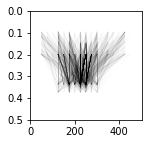

In [16]:
#plot the change in RF center location 
fig = plt.figure(figsize=(2,2))

plt.plot([summary_hq_df['peak_y_early']*25, summary_hq_df['peak_y_late']*25], 
         [summary_hq_df['peak_t_early']*real_time_lag/time_points, summary_hq_df['peak_t_late']*real_time_lag/time_points], marker='None', alpha=0.03, linewidth=0.5, color='k')

axes = plt.gca()
axes.set_xlim([0,500])
axes.set_ylim([0.5,0])

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_position_vs_time_new.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

plt.show()

In [18]:
summary_hq_df['scaled_slope'] =(summary_hq_df['peak_y_late']-summary_hq_df['peak_y_early'])*25/((summary_hq_df['peak_t_late']-summary_hq_df['peak_t_early'])*real_time_lag/time_points)
summary_hq_df['delta_distance'] = summary_hq_df['peak_y_late']*25-summary_hq_df['peak_y_early']*25

tuned_rois = summary_hq_df[(summary_hq_df['delta_distance']>25) | (summary_hq_df['delta_distance']<-25)]

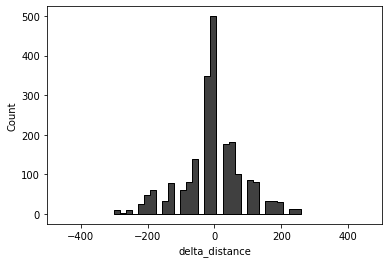

In [19]:
#plot the delta distance histogram

# plt.hist(summary_hq_df['peak_y_late']*25-summary_hq_df['peak_y_early']*25, color = 'k')#, bins=20, )
sns.histplot(data=summary_hq_df, x='delta_distance', binwidth=18, element="step", fill=True, color='k')
axes = plt.gca()
# axes.set_ylim([])
axes.set_xlim([-500,500])

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_hist_position_delta.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

plt.show()

In [ ]:
#separate by indicator type

# # plt.hist(summary_hq_df['peak_y_late']*25-summary_hq_df['peak_y_early']*25, color = 'k')#, bins=20, )
# sns.histplot(data=summary_hq_df, x='delta_distance', hue='indicator', multiple='stack',
#              binwidth=18, element="step", fill=True, palette=["k", "g"])#, "g", "g", ])#, color='k')"g"
# axes = plt.gca()
# # axes.set_ylim([])
# axes.set_xlim([-500,500])

# # Figpath = 'Fig_temp/'
# # savename = Figpath+"GCamp_Spline_Noise_hist_position_delta_indicators.pdf"
# # plt.savefig(savename, transparent=False, bbox_inches='tight')

# plt.show()

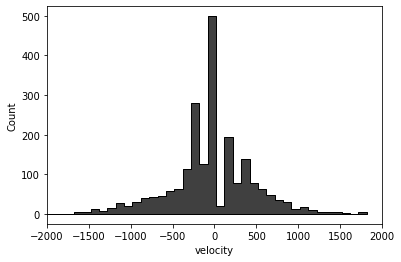

In [20]:
# plt.hist((summary_hq_df['peak_y_late']-summary_hq_df['peak_y_early'])*25/((summary_hq_df['peak_t_late']-summary_hq_df['peak_t_early'])*real_time_lag/time_points), bins=31, color='k', )
sns.histplot(data=summary_hq_df, x='scaled_slope',# hue='field_num',
             binwidth=100, element="step", color='k',
             fill=True)#, palette=["k", "g", "g", "g", "g"])

axes = plt.gca()
# axes.set_ylim([])
axes.set_xlim([-2000,2000])
axes.set_xlabel('velocity')

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_hist_velocity.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

plt.show()

In [ ]:
#separate by indicator type

# # plt.hist((summary_hq_df['peak_y_late']-summary_hq_df['peak_y_early'])*25/((summary_hq_df['peak_t_late']-summary_hq_df['peak_t_early'])*real_time_lag/time_points), bins=31, color='k', )
# sns.histplot(data=summary_hq_df, x='scaled_slope', hue='indicator', multiple='stack',
#              binwidth=100, element="step", fill=True, palette=[ "k", "g"])#, "g", "g"]) #"k",

# axes = plt.gca()
# # axes.set_ylim([])
# axes.set_xlim([-2000,2000])

# axes.set_xlabel('velocity')

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_hist_velocity_indicators.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

# plt.show()

# Stats

In [ ]:
from unidip import UniDip
#https://github.com/BenjaminDoran/unidip

# create bi-modal distribution
dat =summary_hq_df['scaled_slope'].to_numpy()

# sort data so returned indices are meaningful
dat = np.msort(dat)

# get start and stop indices of peaks 
intervals = UniDip(dat, alpha=0.05, ntrials=1000).run()

In [ ]:
for tup in intervals:
    if tup[1] - tup[0] == 0:
        print(dat[tup[0]])
    else:
        print(np.mean(dat[tup[0]:tup[1]]))

In [ ]:
import unidip.dip as dip

print(dip.diptst(dat, numt=1000))
